A senior engineer in your team has requested that you predict the runoff hydrograph using different analytical approaches and contrast and compare the two in a technical report for internal audiences. The catchment details are shown below. The senior requested in particular the development of runoff hydrographs using both an analytical kinematic wave and a pond model approach (`Numerical Models`).

* Catchment area – 2.0 ha with dimensions of 100 m x 200 m
* Slope - 1.0%
* Roughness - 0.100
* Rainfall event - 63mm/h for 50 mins
* Losses - Initial losses of 2mm and continuing losses of 3mm/h.

At the outlet of the catchment, you can assume that flow is instantaneously transmitted from one edge of the catchment to the other in a channel.

Your report needs to present the two predicted hydrographs and a discussion of similarities and differences.  The senior engineer has requested a maximum of a 5 page report exclusive of calculations that can be included as appendices. Excel spreadsheets can be included as appendices. The report needs to adopt appropriate referencing and exploration of data as needed.

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math
import csv
import os

In [189]:
arg_output_dir='./Outputs_CM_Assignment_3/'
step = 60

print(arg_output_dir, step, sep='\n')

./Outputs_CM_Assignment_3/
60


In [190]:
def create_output_dir(arg_output_dir):
    """create output directory if it does not exist

    arguments:
        arg_output_dir = [string] './Outputs_CM_Assignment_2/'
    """
    if not os.path.exists(arg_output_dir):
        os.makedirs(arg_output_dir)

In [191]:
create_output_dir(arg_output_dir)

In [192]:
catch_area = 2          # Ha
width = 100             # m
slope = 1               # %
roughness = 0.1         # s/m^1/3
intensity = 63          # mm/h
duration = 50           # min
ini_loss = 2            # mm
cont_loss = 3           # mm/h

catch_area = catch_area*10000
length = catch_area/width
slope = slope/100
intensity = intensity/(1000*3600)
duration = duration*60
ini_loss = ini_loss/1000
cont_loss = cont_loss/(1000*3600)

print(
    catch_area,
    width,
    length,
    slope,
    roughness,
    intensity,
    duration,
    ini_loss,
    cont_loss,
    sep='\n')

20000
100
200.0
0.01
0.1
1.75e-05
3000
0.002
8.333333333333333e-07


In [193]:
ini_loss_dur = ini_loss/intensity
rainfall_excess = intensity - cont_loss
alpha = math.sqrt(slope)/roughness
beta = 5/3
time_conc_rel = (length/(alpha*(rainfall_excess**(beta - 1))))**(1/beta)
time_conc_abs = time_conc_rel + ini_loss_dur

print(
    ini_loss_dur,
    rainfall_excess,
    alpha,
    beta,
    time_conc_rel,
    time_conc_abs,
    sep='\n')

114.28571428571429
1.6666666666666664e-05
1.0
1.6666666666666667
1958.2967247219542
2072.5824390076687


In [194]:
var = {
    'catch_area':catch_area, 'width':width, 'length':length, 'slope':slope, 'roughness':roughness, 
    'intensity':intensity, 'duration':duration, 'ini_loss':ini_loss, 'cont_loss':cont_loss, 'ini_loss_dur':ini_loss_dur, 
    'rainfall_excess':rainfall_excess, 'alpha':alpha, 'beta':beta, 'time_conc_rel':time_conc_rel, 'time_conc_abs':time_conc_abs
    }

spaces = [' '*ind for ind in [max([len(ind) for ind in var.keys()]) - ind for ind in [len(ind) for ind in var.keys()]]]

for ind1, ind2 in zip(spaces, var.items()):
    print('{}{}:\t{}'.format(ind2[0], ind1, ind2[1]))

catch_area     :	20000
width          :	100
length         :	200.0
slope          :	0.01
roughness      :	0.1
intensity      :	1.75e-05
duration       :	3000
ini_loss       :	0.002
cont_loss      :	8.333333333333333e-07
ini_loss_dur   :	114.28571428571429
rainfall_excess:	1.6666666666666664e-05
alpha          :	1.0
beta           :	1.6666666666666667
time_conc_rel  :	1958.2967247219542
time_conc_abs  :	2072.5824390076687


In [195]:
input_data = [{'key': key, 'value':val} for key, val in var.items()]
key_input = ['key', 'value']

with open (
    file='{}_data_Kinematic_and_Pond_model_{:06}_{:04}_{:04}_{:06}.csv'.format(
        arg_output_dir, int(catch_area), int(width), int(length), step),
    mode='w',
    newline='') as file:
    writer = csv.DictWriter(file, fieldnames=key_input)
    writer.writeheader()
    writer.writerows(input_data)

In [196]:
def kinematic_wave_eq(
    step,
    ini_loss_dur,
    time_conc_abs,
    duration,
    rainfall_excess,
    alpha,
    beta,
    width,
    length
    ):

    # rl: rising limb
    rl_time_sec = np.concatenate((
        np.arange(start=0, stop=ini_loss_dur, step=step),
        np.array(object=[ini_loss_dur]),
        np.arange(start=ini_loss_dur - ini_loss_dur%step + step, stop=time_conc_abs, step=step),
        np.array(object=[time_conc_abs])
        ))
    rl_rel_time_sec = np.where(rl_time_sec - ini_loss_dur < 0, 0, rl_time_sec - ini_loss_dur)
    rl_depth = rl_rel_time_sec*rainfall_excess
    rl_unit_flow_rate = alpha*rl_depth**beta
    rl_flow_rate = rl_unit_flow_rate*width

    # el: equilibrium limb
    el_time_sec = np.arange(start=rl_time_sec[-1] - rl_time_sec[-1]%step + step, stop=duration, step=step)
    el_rel_time_sec = el_time_sec - ini_loss_dur
    el_depth = np.ones(shape=el_rel_time_sec.size)*rl_depth[-1]
    el_unit_flow_rate = np.ones(shape=el_rel_time_sec.size)*rl_unit_flow_rate[-1]
    el_flow_rate = np.ones(shape=el_rel_time_sec.size)*rl_flow_rate[-1]

    # fl: falling limb
    fl_time_sec = np.concatenate((
        np.array([duration]),
        np.arange(start=duration - duration%step + step, stop=duration*7, step=step),
        ))
    fl_rel_time_sec = fl_time_sec - ini_loss_dur
    fl_unit_flow_rate = []
    for t in fl_rel_time_sec:
        def solver_function(q, tr=duration - ini_loss_dur, t=t, i=rainfall_excess, l=length, b=beta, a=alpha):
            return q - i*l + (t - tr)*i*b*(a**(1/b))*(q**((b - 1)/b))
        q = optimize.root(fun=solver_function, x0=0, tol=1E-10)
        q = q.x[0]
        fl_unit_flow_rate.append(q)
    fl_unit_flow_rate = np.array(fl_unit_flow_rate)
    fl_depth = (fl_unit_flow_rate/alpha)**(1/beta)
    fl_flow_rate = fl_unit_flow_rate*width

    # wrapping up
    time_sec = np.concatenate((
        rl_time_sec,
        el_time_sec,
        fl_time_sec
        ))
    time_min = time_sec/60
    rel_time_sec = np.concatenate((
        rl_rel_time_sec,
        el_rel_time_sec,
        fl_rel_time_sec
        ))
    depth = np.concatenate((
        rl_depth,
        el_depth,
        fl_depth
        ))
    unit_flow_rate = np.concatenate((
        rl_unit_flow_rate,
        el_unit_flow_rate,
        fl_unit_flow_rate
        ))
    flow_rate = np.concatenate((
        rl_flow_rate,
        el_flow_rate,
        fl_flow_rate
        ))

    return pd.DataFrame(
        data=np.column_stack((
            time_min,
            time_sec,
            rel_time_sec,
            depth,
            unit_flow_rate,
            flow_rate
            )),
        columns=['t_min', 't_sec', 't_rel', 'y', 'q', 'Q'])

In [197]:
kin_results = kinematic_wave_eq(
    step,
    ini_loss_dur,
    time_conc_abs,
    duration,
    rainfall_excess,
    alpha,
    beta,
    width,
    length
    )
kin_results.to_csv(
    path_or_buf='{}Q_Kinematic_model_{:06}_{:04}_{:04}_{:06}.csv'.format(
        arg_output_dir, int(catch_area), int(width), int(length), step), index=False)

kin_results

,t_min,t_sec,t_rel,y,q,Q
0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,1.000000,60.000000,0.000000,0.000000,0.000000e+00,0.000000
2,1.904762,114.285714,0.000000,0.000000,0.000000e+00,0.000000
3,2.000000,120.000000,5.714286,0.000095,1.986176e-07,0.000020
4,3.000000,180.000000,65.714286,0.001095,1.163718e-05,0.001164
...,...,...,...,...,...,...
347,345.000000,20700.000000,20585.714286,0.000557,3.773897e-06,0.000377
348,346.000000,20760.000000,20645.714286,0.000554,3.742192e-06,0.000374
349,347.000000,20820.000000,20705.714286,0.000552,3.710859e-06,0.000371
350,348.000000,20880.000000,20765.714286,0.000549,3.679892e-06,0.000368


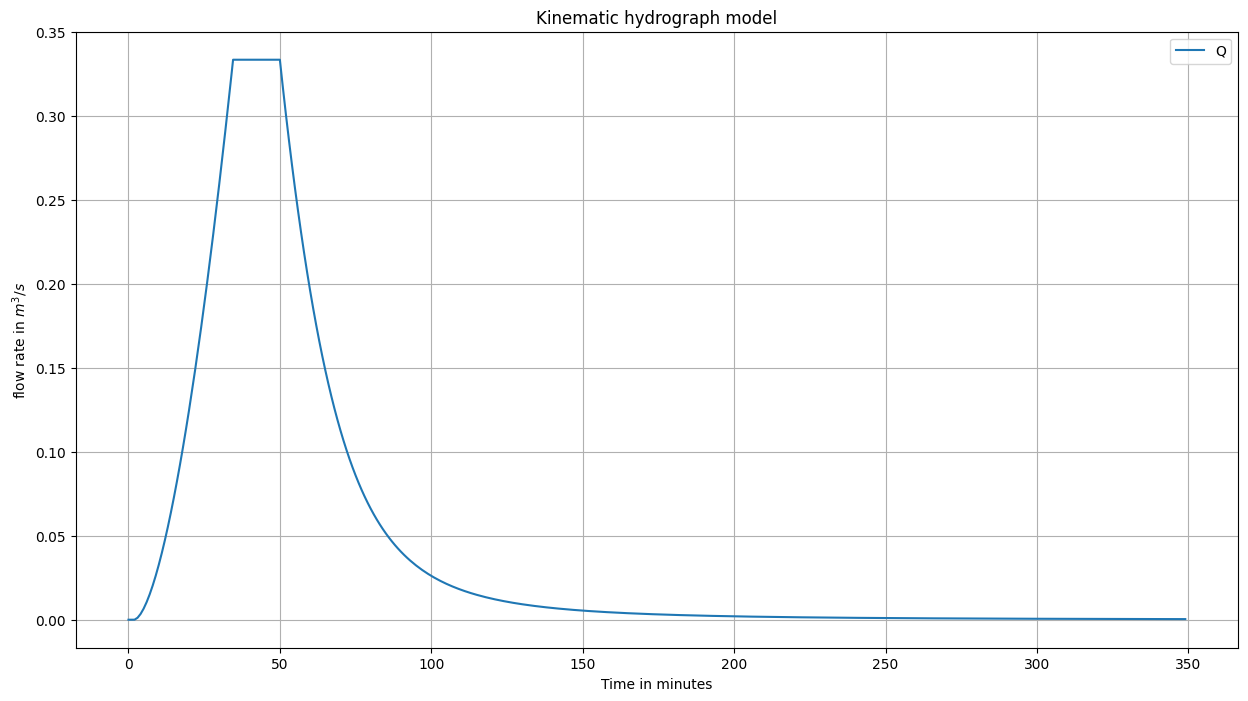

In [198]:
fig, ax = plt.subplots(figsize=(15,8))
ax = kin_results.plot(
    x='t_min',
    y='Q',
    kind='line',
    ax=ax,
    title='Kinematic hydrograph model',
    grid=True,
    xlabel='Time in minutes',
    ylabel='flow rate in $m^{3}/s$'
    )
fig.savefig(
    fname='{}Q_Kinematic_model_{:06}_{:04}_{:04}_{:06}.png'.format(
        arg_output_dir, int(catch_area), int(width), int(length), step))

In [199]:
def pond_model_eq(
    step,
    ini_loss_dur,
    time_conc_abs,
    duration,
    rainfall_excess,
    alpha,
    beta,
    width,
    length
    ):

    time_sec = np.concatenate((
        np.arange(start=0, stop=ini_loss_dur, step=step),
        np.array([ini_loss_dur]),
        np.arange(start=ini_loss_dur - ini_loss_dur%step + step, stop=time_conc_abs, step=step),
        np.array([time_conc_abs]),
        np.arange(start=time_conc_abs - time_conc_abs%step + step, stop=duration, step=step),
        np.array([duration]),
        np.arange(start=duration - duration%step + step, stop=duration*7, step=step)
    ))
    time_min = time_sec/60

    delta_time = np.concatenate((
        np.array([0]),
        np.diff(a=time_sec)
        ))

    i_prom = np.where((time_sec <= ini_loss_dur) | (time_sec > duration), 0, rainfall_excess*width*length*delta_time)

    depth = []
    y0 = 0
    for dt, ip in zip(delta_time, i_prom):
        def solver_function(y1, y0=y0, w=width, l=length, a=alpha, b=beta, dt=dt, ip=ip):
            return ip - w*a*(y1**b + y0**b)*dt/2 - w*l*(y1 - y0)
        y1 = optimize.root(fun=solver_function, x0=0, tol=1E-10)
        y1 = y1.x[0]
        depth.append(y1)
        y0 = y1
    depth = np.array(depth)

    o_prom = []
    y0 = 0
    for y1, dt in zip(depth, delta_time):
        op = width*alpha*(y0**beta + y1**beta)*dt/2
        o_prom.append(op)
        y0 = y1
    o_prom = np.array(o_prom)

    flow_rate = width*alpha*(depth**beta)

    return pd.DataFrame(
        data=np.column_stack((time_min, time_sec, delta_time, i_prom, o_prom, depth, flow_rate)),
        columns=['t_min', 't_sec', 'dt', 'i_prom', 'o_prom', 'y', 'Q'])

In [200]:
pond_results = pond_model_eq(
    step,
    ini_loss_dur,
    time_conc_abs,
    duration,
    rainfall_excess,
    alpha,
    beta,
    width,
    length
    )
pond_results.to_csv(
    path_or_buf='{}Q_Pond_model_{:06}_{:04}_{:04}_{:06}.csv'.format(
        arg_output_dir, int(catch_area), int(width), int(length), step), index=False)

pond_results

,t_min,t_sec,dt,i_prom,o_prom,y,Q
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,60.000000,60.000000,0.000000,0.000000,0.000000,0.000000
2,1.904762,114.285714,54.285714,0.000000,0.000000,0.000000,0.000000
3,2.000000,120.000000,5.714286,1.904762,0.000057,0.000095,0.000020
4,3.000000,180.000000,60.000000,20.000000,0.035413,0.001093,0.001161
...,...,...,...,...,...,...,...
347,345.000000,20700.000000,60.000000,0.000000,0.148263,0.001717,0.002462
348,346.000000,20760.000000,60.000000,0.000000,0.147204,0.001710,0.002445
349,347.000000,20820.000000,60.000000,0.000000,0.146156,0.001702,0.002427
350,348.000000,20880.000000,60.000000,0.000000,0.145117,0.001695,0.002410


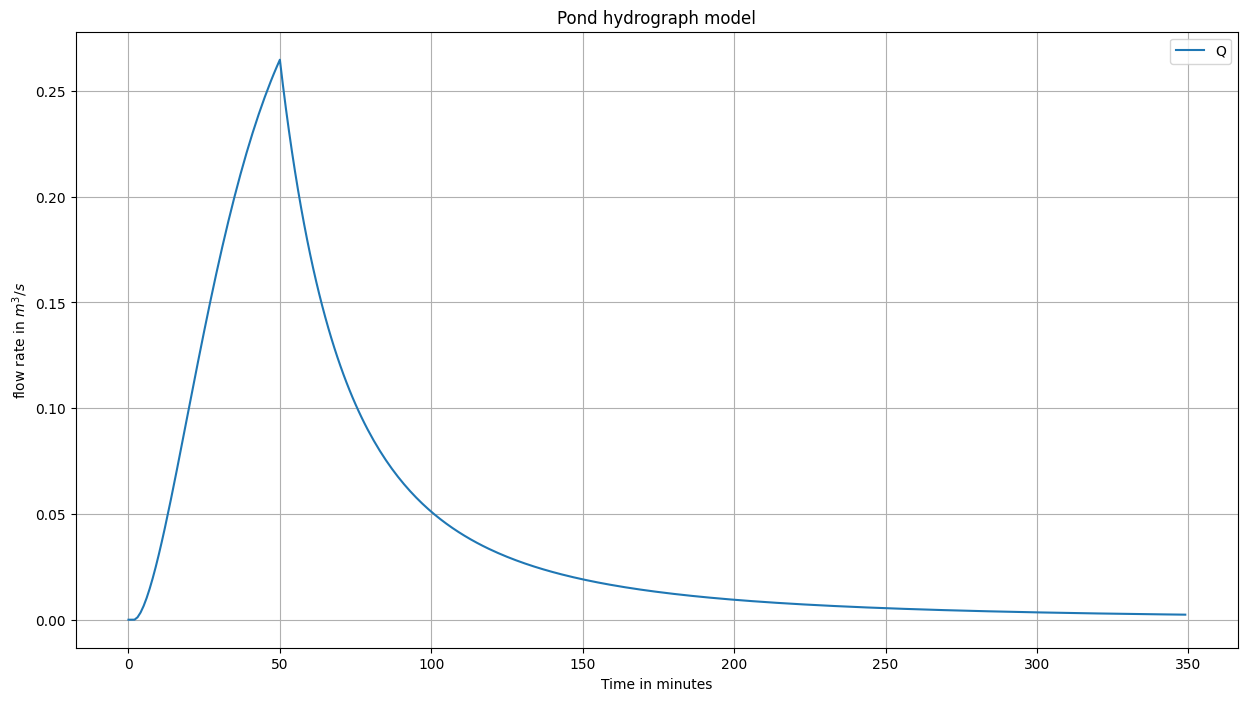

In [201]:
fig, ax = plt.subplots(figsize=(15,8))
ax = pond_results.plot(
    x='t_min',
    y='Q',
    kind='line',
    ax=ax,
    title='Pond hydrograph model',
    grid=True,
    xlabel='Time in minutes',
    ylabel='flow rate in $m^{3}/s$'
    )
fig.savefig(
    fname='{}Q_Pond_model_{:06}_{:04}_{:04}_{:06}.png'.format(
        arg_output_dir, int(catch_area), int(width), int(length), step))

In [202]:
kin_pond_results = pd.concat(objs=[
    kin_results.t_sec,
    kin_results.t_min,
    kin_results.Q,
    pond_results.t_sec,
    pond_results.t_min,
    pond_results.Q
    ], axis=1)
kin_pond_results.columns = ['t_sec_kinematic', 't_min_kinematic', 'Q_Kinematic_model', 't_sec_pond', 't_min_pond', 'Q_Pond_model']
kin_pond_results.to_csv(
    path_or_buf='{}Kinematic_and_Pond_model_{:06}_{:04}_{:04}_{:06}.csv'.format(
        arg_output_dir, int(catch_area), int(width), int(length), step), index=False)

kin_pond_results

,t_sec_kinematic,t_min_kinematic,Q_Kinematic_model,t_sec_pond,t_min_pond,Q_Pond_model
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,60.000000,1.000000,0.000000,60.000000,1.000000,0.000000
2,114.285714,1.904762,0.000000,114.285714,1.904762,0.000000
3,120.000000,2.000000,0.000020,120.000000,2.000000,0.000020
4,180.000000,3.000000,0.001164,180.000000,3.000000,0.001161
...,...,...,...,...,...,...
347,20700.000000,345.000000,0.000377,20700.000000,345.000000,0.002462
348,20760.000000,346.000000,0.000374,20760.000000,346.000000,0.002445
349,20820.000000,347.000000,0.000371,20820.000000,347.000000,0.002427
350,20880.000000,348.000000,0.000368,20880.000000,348.000000,0.002410


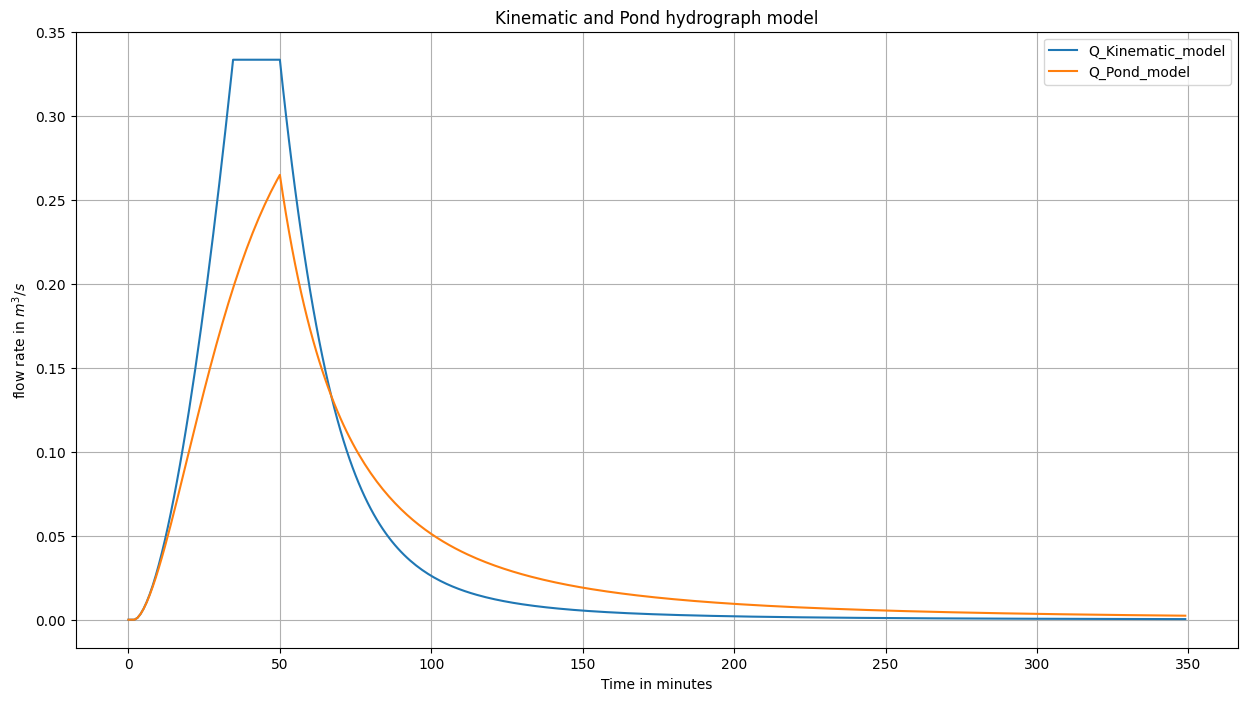

In [203]:
fig, ax = plt.subplots(figsize=(15,8))

ax = kin_pond_results.plot(
    x='t_min_kinematic',
    y='Q_Kinematic_model',
    kind='line',
    ax=ax
    )

ax = kin_pond_results.plot(
    x='t_min_pond',
    y='Q_Pond_model',
    kind='line',
    ax=ax
    )

ax.set_title('Kinematic and Pond hydrograph model')
ax.grid(visible=True)
ax.set_xlabel(xlabel='Time in minutes')
ax.set_ylabel(ylabel='flow rate in $m^{3}/s$')

fig.savefig(
    fname='{}Kinematic_and_Pond_model_{:06}_{:04}_{:04}_{:06}.png'.format(
        arg_output_dir, int(catch_area), int(width), int(length), step))

In [204]:
# kin_results.t_min.apply(lambda arg: pd.Timedelta(minutes=arg))